In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from lightgbm import LGBMClassifier
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings

from pprint import pprint
import mlflow 
import mlflow.sklearn
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [4]:
from src.p7_constantes import (
    MODEL_DIR,
    DATA_INTERIM,
    LOCAL_URI,
    LOCAL_HOST,
    LOCAL_PORT,
    
)

from src.p7_simple_kernel import CONFIG_SIMPLE, LIGHTGBM_PARAMS_SIMPLE
from src.p7_evaluate import lgb_cross_evaluate, train_and_test_lgbm
from src.p7_util import format_time_min, format_time, timer


In [5]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("Scikit-learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.4.2
MLFlow: 2.12.1


In [6]:
subdir = "light_simple/"

In [7]:
config = CONFIG_SIMPLE
config

{'debug': False,
 'nan_as_cat': True,
 'data_output_dir': 'data/interim/',
 'data_filename': 'all_data_simple_kernel_ohe.csv',
 'generate_submission_files': True,
 'model_dir': 'models/',
 'model_subdir': 'light_simple/',
 'importance_filename': 'feature_importance.csv',
 'submission_filename': 'lightgbm_simple_submission.csv',
 'num_threads': 16,
 'stratified_kfold': True,
 'num_folds': 10,
 'early_stopping': 100,
 'random_seed': 1001}

In [11]:
# Soumission du kernel simple initial il contient toutes les prédictions pour tous les folds de validation
df_submission = pd.read_csv(os.path.join(config['model_dir'], config['model_subdir'], config['submission_filename']))
print(df_submission.shape)
df_submission.head(12)

(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.036910
1,100005,0.145792
2,100013,0.029060
3,100028,0.038685
4,100038,0.156258
5,100042,0.043869
6,100057,0.005929
7,100065,0.027469
8,100066,0.010390
9,100067,0.058888


In [12]:
del df_submission
gc.collect()

1005

# Essai avec toutes les features

In [9]:
"""from src.p7_evaluate import evaluate_lgbm, train_and_test_lgbm
from src.p7_simple_kernel import LIGHTGBM_PARAMS_SIMPLE"""

In [10]:
df = pd.read_csv(os.path.join(DATA_INTERIM, config["data_filename"]))
data = df[df["TARGET"].notnull()]
del df
gc.collect()
print("Forme de data:", data.shape)

Forme de data: (307507, 794)


In [29]:
train, test = train_test_split(data, test_size=0.2)
del data
gc.collect()
print("Forma de train :", train.shape)
print("Forma de test :", test.shape)

Forma de train : (246005, 794)
Forma de test : (61502, 794)


In [102]:
#from src.p7_simple_kernel import CONFIG_SIMPLE, LIGHTGBM_PARAMS_SIMPLE
from src.p7_evaluate import train_and_test_lgbm

In [32]:
params = {
    "random_state": config["random_seed"],
    "nthread": config["num_threads"],
    }
hyperparams = LIGHTGBM_PARAMS_SIMPLE

In [39]:
LIGHTGBM_PARAMS_SIMPLE

{'n_estimators': 10000,
 'learning_rate': 0.02,
 'num_leaves': 34,
 'colsample_bytree': 0.9497036,
 'subsample': 0.8715623,
 'max_depth': 8,
 'reg_alpha': 0.041545473,
 'reg_lambda': 0.0735294,
 'min_split_gain': 0.0222415,
 'min_child_weight': 39.3259775,
 'silent': -1,
 'verbose': -1}

In [19]:
from src.p7_evaluate import lgb_f1_score

# Essai avec les paramètres du kernel

In [1]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    
    "num_leaves": 34,
    "learning_rate": 0.05,
    #"colsample_bytree":0.9497036,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_threads": 32,
    "verbose": -1, # Supprime la plupart des warnings lgbm
}

In [56]:
"""from src.p7_evaluate import lgb_cross_evaluate
from src.p7_util import format_time_min, format_time, timer"""

In [58]:
with timer("Process cross validation"):
    #cv_results = lgb_cross_evaluate(data.sample(30_000, random_state=42), params, verbose=False)
    cv_results = lgb_cross_evaluate(data, params, verbose=False)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	cv_agg's valid binary_logloss: 0.246819 + 0.00104952	cv_agg's valid auc: 0.763019 + 0.00487744	cv_agg's valid accuracy: 0.919316 + 6.08394e-05	cv_agg's valid balanced accuracy: 0.500558 + 0.000235245	cv_agg's valid recall: 0.00116818 + 0.000466298	cv_agg's valid weighted_recall: 0.919316 + 6.08394e-05	cv_agg's valid f1: 0.0023318 + 0.000929805	cv_agg's valid precision: 0.726129 + 0.223334
Process cross validation - duration (hh:mm:ss) : 0:03:05


In [55]:
print(len(cv_results['valid auc-mean']))
print(cv_results.keys())
for k in cv_results.keys():
    print(f"len({k}) : {len(cv_results[k])}")

61
dict_keys(['valid binary_logloss-mean', 'valid binary_logloss-stdv', 'valid auc-mean', 'valid auc-stdv', 'valid accuracy-mean', 'valid accuracy-stdv', 'valid balanced accuracy-mean', 'valid balanced accuracy-stdv', 'valid recall-mean', 'valid recall-stdv', 'valid weighted_recall-mean', 'valid weighted_recall-stdv', 'valid f1-mean', 'valid f1-stdv', 'valid precision-mean', 'valid precision-stdv'])
len(valid binary_logloss-mean) : 61
len(valid binary_logloss-stdv) : 61
len(valid auc-mean) : 61
len(valid auc-stdv) : 61
len(valid accuracy-mean) : 61
len(valid accuracy-stdv) : 61
len(valid balanced accuracy-mean) : 61
len(valid balanced accuracy-stdv) : 61
len(valid recall-mean) : 61
len(valid recall-stdv) : 61
len(valid weighted_recall-mean) : 61
len(valid weighted_recall-stdv) : 61
len(valid f1-mean) : 61
len(valid f1-stdv) : 61
len(valid precision-mean) : 61
len(valid precision-stdv) : 61


Train shape : (246005, 794)
Eval shape : (61502, 794)
Nombre de prédicteurs : 792
Nombre de features catégorielles : 0

Entraînement...
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.24122	train's auc: 0.78201	eval's binary_logloss: 0.247578	eval's auc: 0.762994
[100]	train's binary_logloss: 0.231597	train's auc: 0.804764	eval's binary_logloss: 0.241756	eval's auc: 0.777923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's binary_logloss: 0.225895	train's auc: 0.818526	eval's binary_logloss: 0.239682	eval's auc: 0.783424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

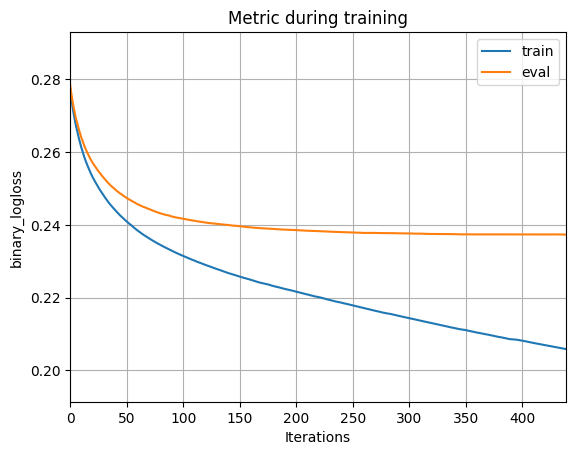

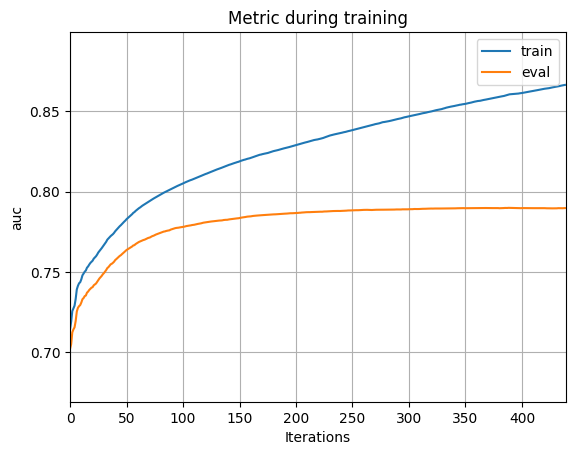

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56522
         1.0       0.53      0.05      0.09      4980

    accuracy                           0.92     61502
   macro avg       0.72      0.52      0.53     61502
weighted avg       0.89      0.92      0.89     61502

auc : 78.99%
accuracy : 91.94%
balanced_accuracy : 52.35%
f1 : 9.30%
precision : 52.59%
recall : 5.10%
weighted_recall : 91.94%


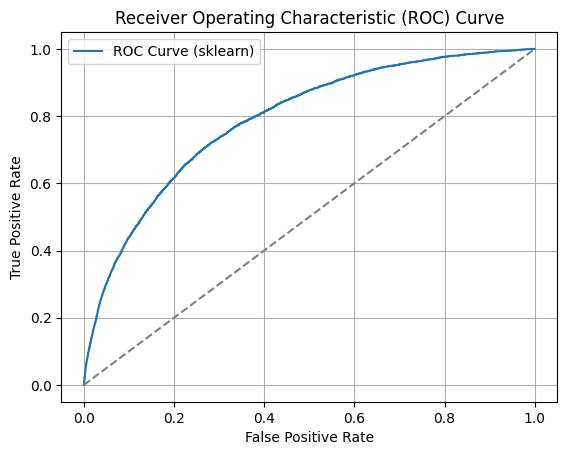

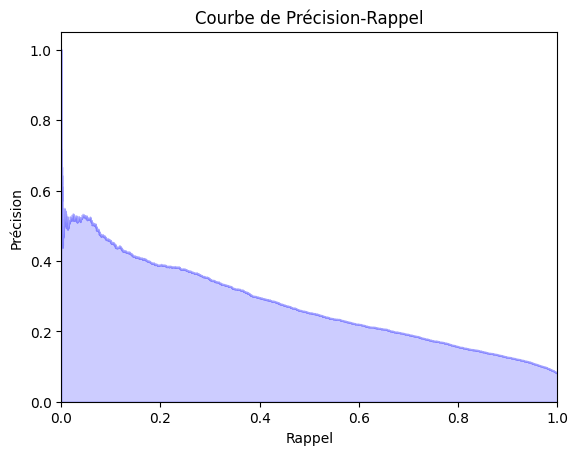

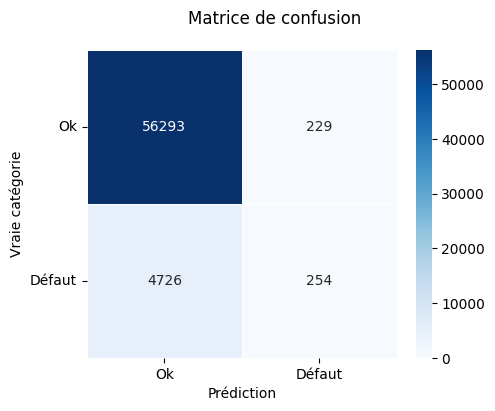

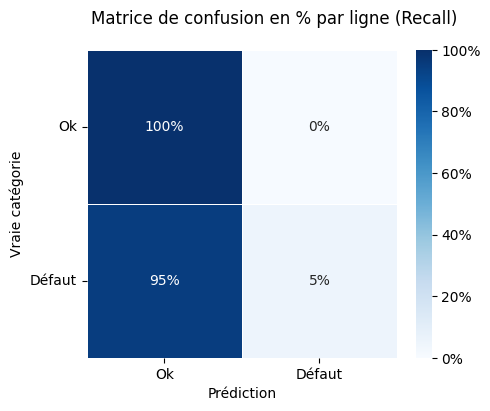

In [101]:
dic_score = train_and_test_lgbm(train, test, params, plot=True, verbose=True)

In [93]:
dic_score

{'auc_score': 0.7899059526737926}

importer les données de train

In [15]:
df = pd.read_csv(os.path.join(DATA_INTERIM, config["data_filename"]))
"""to_drop = sel_var(df.columns, "Unnamed")
if to_drop:
    df = df.drop(to_drop, axis=1)
df = df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))"""
train = df[df["TARGET"].notnull()]
del df
#del to_drop
gc.collect()

print("Forme de train:", train.shape)

Forme de train: (307507, 794)


In [19]:
# échantillon
train_sampled = train.sample(60_000, random_state=42)
config['num_folds'] = 5

Training until validation scores don't improve for 100 rounds
[50]	training's binary_logloss: 0.249748	valid_1's binary_logloss: 0.255777
[100]	training's binary_logloss: 0.235101	valid_1's binary_logloss: 0.248142
[150]	training's binary_logloss: 0.225088	valid_1's binary_logloss: 0.24472
[200]	training's binary_logloss: 0.217464	valid_1's binary_logloss: 0.242919
[250]	training's binary_logloss: 0.21183	valid_1's binary_logloss: 0.242099
[300]	training's binary_logloss: 0.206791	valid_1's binary_logloss: 0.241659
[350]	training's binary_logloss: 0.202702	valid_1's binary_logloss: 0.24134
[400]	training's binary_logloss: 0.19873	valid_1's binary_logloss: 0.241199
[450]	training's binary_logloss: 0.195319	valid_1's binary_logloss: 0.241142
[500]	training's binary_logloss: 0.192003	valid_1's binary_logloss: 0.241278
[550]	training's binary_logloss: 0.188809	valid_1's binary_logloss: 0.241325
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.195255	valid_1's binary_lo

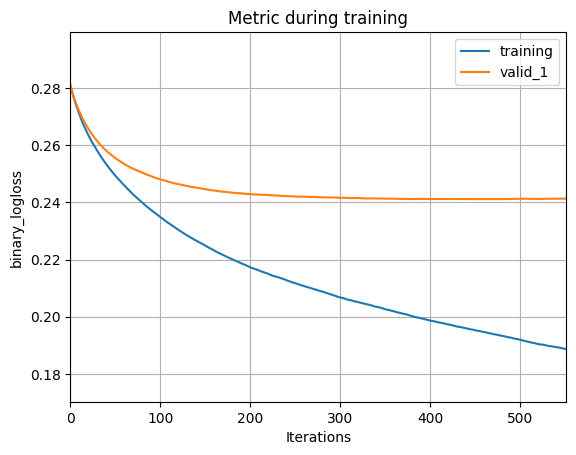

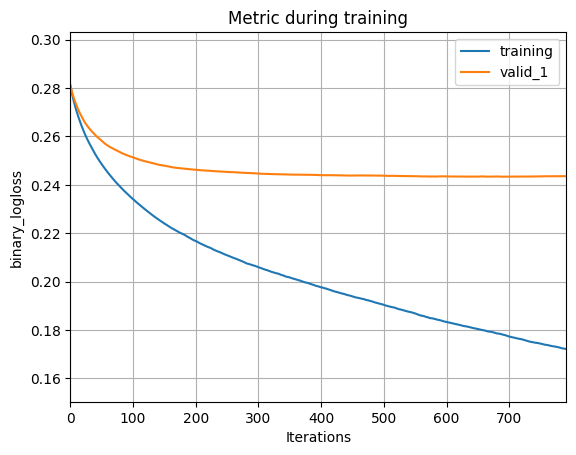

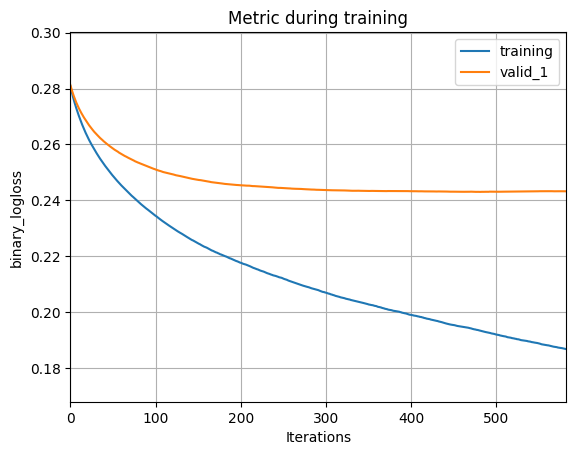

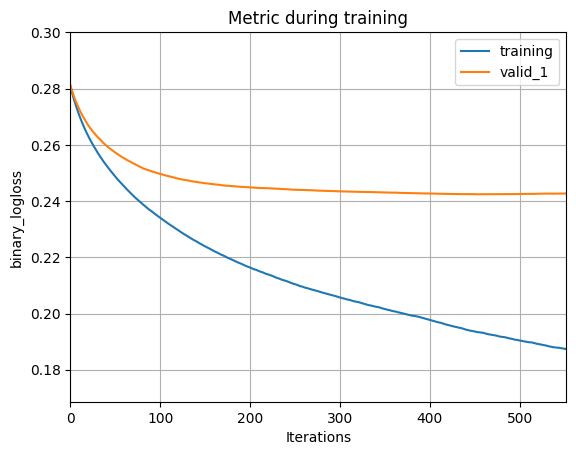

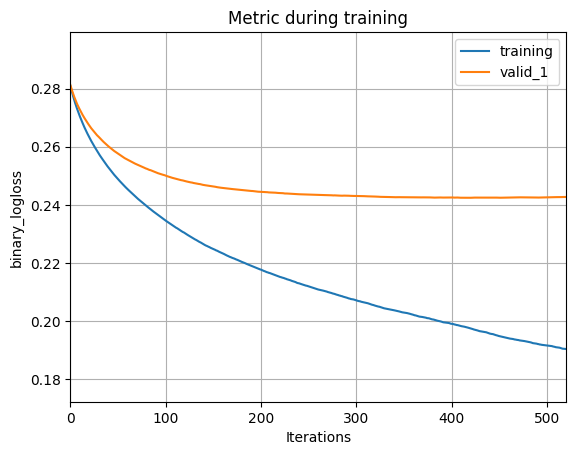

In [26]:
params = {
    "random_state": config["random_seed"],
    "nthread": config["num_threads"],
    }
evaluate_lgbm(train_sampled, params, hyperparams=LIGHTGBM_PARAMS_SIMPLE, config=config)

# Essai avec N_37 de debug_lgb_search_3 (20 features)

In [8]:
df = pd.read_csv(os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"))
df = df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    
data = df[df['TARGET'].notnull()]
del df
gc.collect()

print("Forme de data avec Target :", data.shape)
data.head()

Forme de data avec Target : (307507, 794)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
config

{'debug': False,
 'nan_as_cat': True,
 'data_output_dir': 'data/interim/',
 'data_filename': 'all_data_simple_kernel_ohe.csv',
 'generate_submission_files': True,
 'model_dir': 'models/',
 'model_subdir': 'light_simple/',
 'importance_filename': 'feature_importance.csv',
 'submission_filename': 'lightgbm_simple_submission.csv',
 'num_threads': 16,
 'stratified_kfold': True,
 'num_folds': 10,
 'early_stopping': 100,
 'random_seed': 1001}

In [10]:
sorted_features_by_importance = pd.read_csv(os.path.join(config['model_dir'], config['model_subdir'], config['importance_filename'])).set_index("feature").index.tolist()
print(len(sorted_features_by_importance))
sorted_features_by_importance[:10]

792


['PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'ACTIVE_DAYS_CREDIT_MAX']

In [11]:
not_predictors = [
    'TARGET',
    "SK_ID_CURR",
    "SK_ID_BUREAU",
    "SK_ID_PREV",
    "index",
    "level_0",
    ]
sorted_features_by_importance = list(filter(lambda v: v not in not_predictors, data.columns))

In [12]:
len(sorted_features_by_importance)

792

In [13]:
predictors = sorted_features_by_importance[:21]

In [14]:
# hyperparams
bagging_fraction = 0.8714674596466919
bagging_freq = 5
boosting_type = 'gbdt'
feature_fraction = 0.8822692279847044
lamda_l1 = 6.077887725730009
lambda_l2 = 0.0013237454270220415
learning_rate = 0.04394634755581446
max_bin = 288
min_child_samples = 44
num_leaves = 256
n_estimators = 280

hyperparams = {
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'boosting_type': boosting_type,
    'feature_fraction': feature_fraction,
    'reg_alpha': lamda_l1,
    'reg_lambda': lambda_l2,
    'learning_rate': learning_rate,
    'max_bin': max_bin,
    'min_child_samples': min_child_samples,
    'num_leaves': num_leaves,
    
}

In [17]:
dic = lgb_cross_evaluate(data[predictors + ['TARGET']], params=hyperparams)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data points in the train set: 276756, number of used features: 20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data points in the train set: 276756, number of used features: 20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data

In [18]:
train_df, test_df = train_test_split(data[predictors + ['TARGET']], test_size=0.25, shuffle=True, stratify=data['TARGET'])
print("train_df.shape", train_df.shape)
print("test_df.shape", test_df.shape)

train_df.shape (230630, 22)
test_df.shape (76877, 22)


In [25]:
params = hyperparams
params['metric'] = {'auc', 'binary'}

Train shape : (230630, 22)
Eval shape : (76877, 22)
Nombre de prédicteurs : 21
Nombre de features catégorielles : 0

Entraînement...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 20
[LightGBM] [Info] Start training from score 0.080731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	train's auc: 0.807525	train's binary_logloss: 0.23809	eval's auc: 0.675791	eval's binary_logloss: 0.265432
Durée du fit (hh:mm:ss): 0:00:05
Prédictions et scoring...


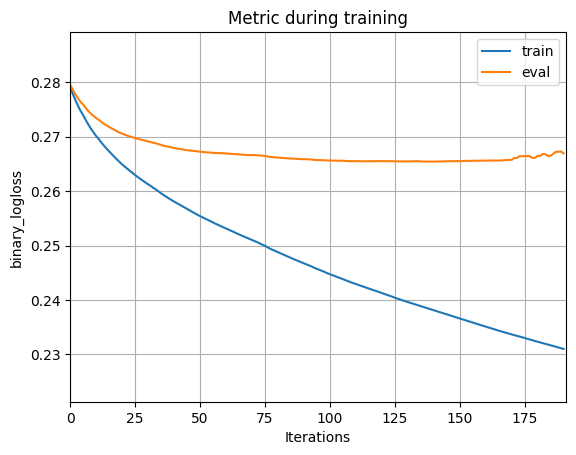

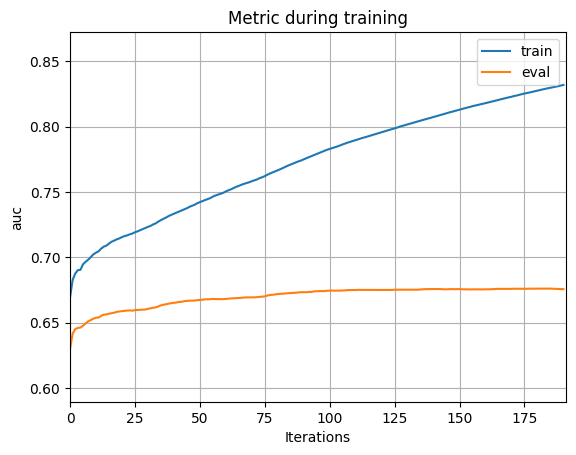

              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     70671
         1.0       0.08      1.00      0.15      6206

    accuracy                           0.08     76877
   macro avg       0.54      0.50      0.07     76877
weighted avg       0.93      0.08      0.01     76877

auc : 67.58%
accuracy : 8.09%
balanced_accuracy : 50.01%
f1 : 14.94%
precision : 8.07%
recall : 100.00%
weighted_recall : 8.09%


({'auc': 0.6757909414644566,
  'accuracy': 0.08092147196170506,
  'balanced_accuracy': 0.5001061255677718,
  'f1': 0.14941975249193432,
  'precision': 0.08074210923473238,
  'recall': 1.0,
  'weighted_recall': 0.08092147196170506},
 4.8650970458984375)

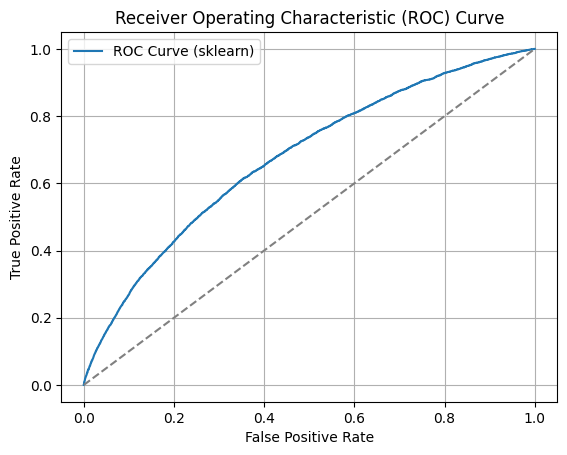

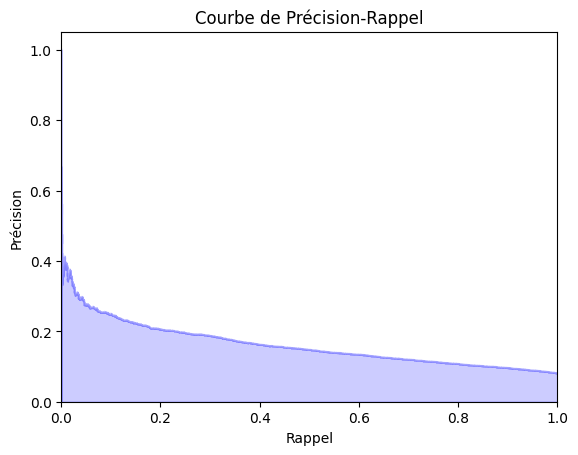

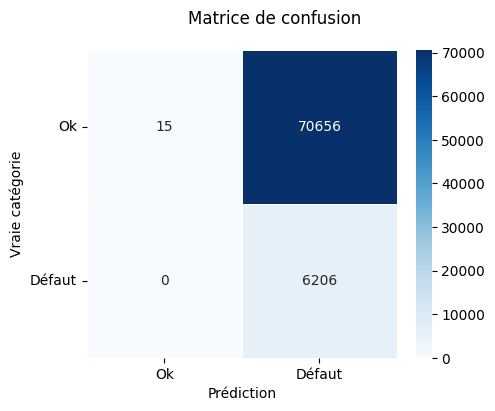

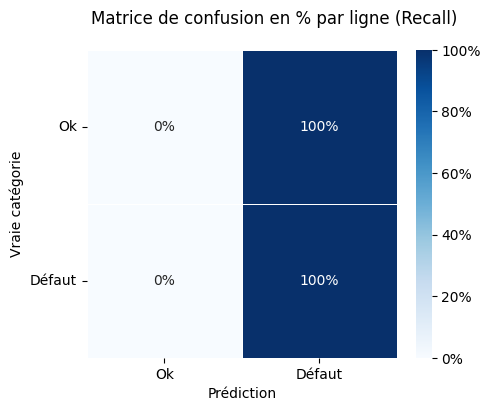

In [27]:
train_and_test_lgbm(train_df, test_df, params=params)

In [26]:
from src.p7_evaluate import evaluate_lgbm

[LightGBM] [Warning] feature_fraction is set=0.8822692279847044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8822692279847044
[LightGBM] [Warning] bagging_fraction is set=0.8714674596466919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714674596466919
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8822692279847044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8822692279847044
[LightGBM] [Warning] bagging_fraction is set=0.8714674596466919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714674596466919
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 22342, number of negative: 254414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005776 seconds.
You ca

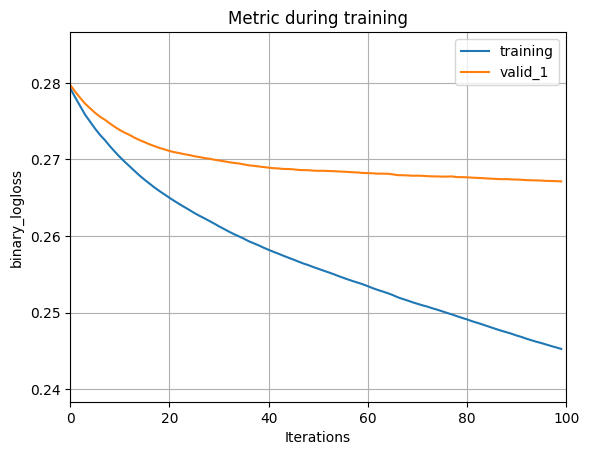

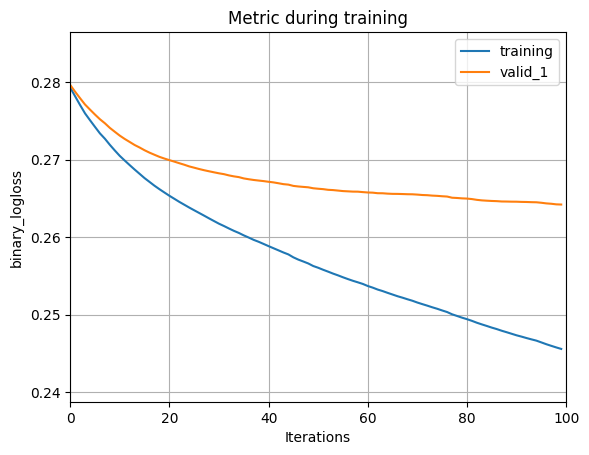

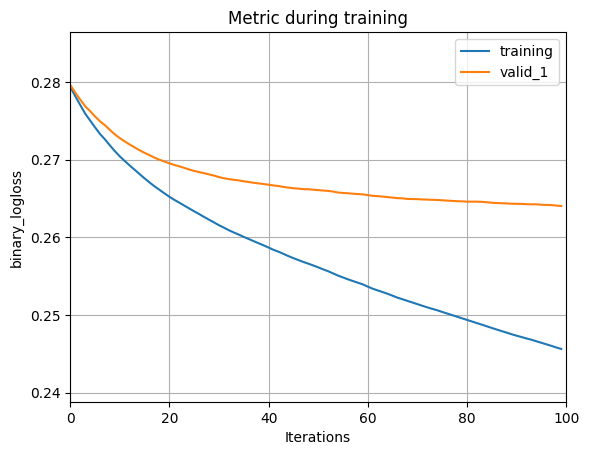

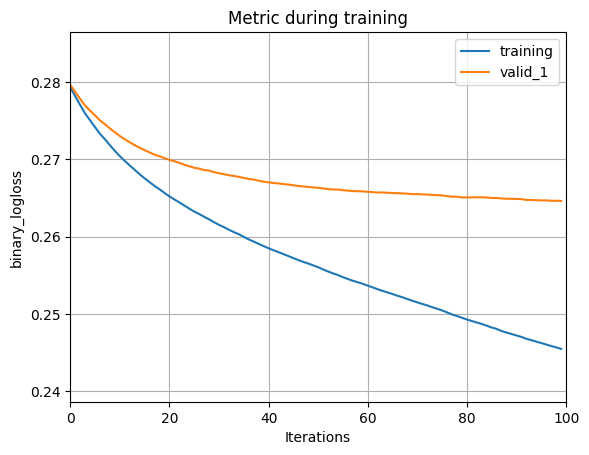

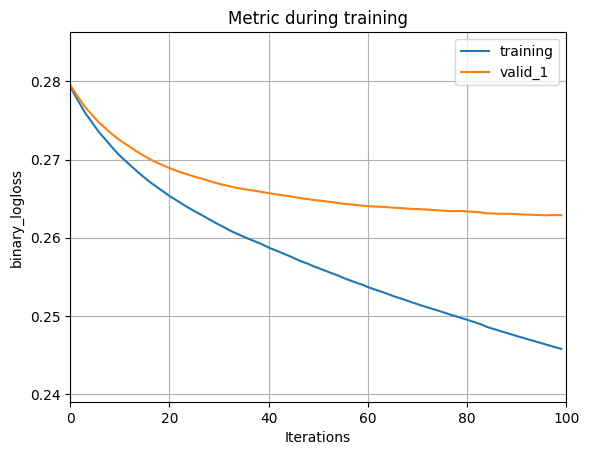

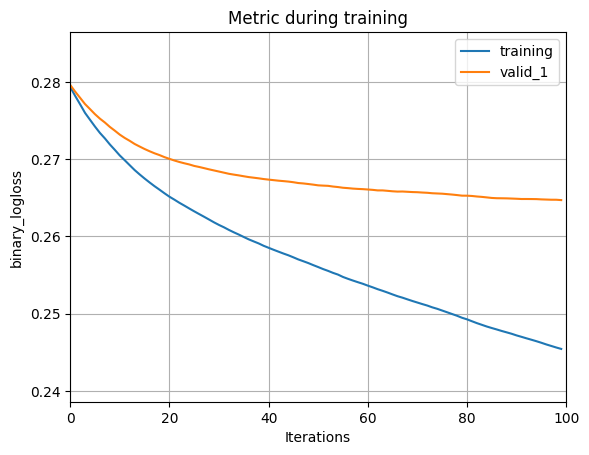

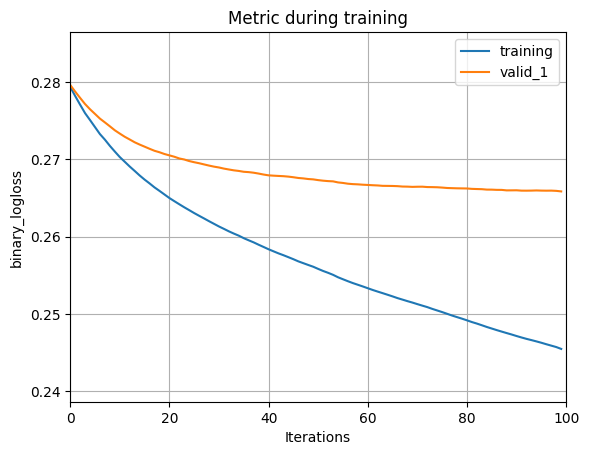

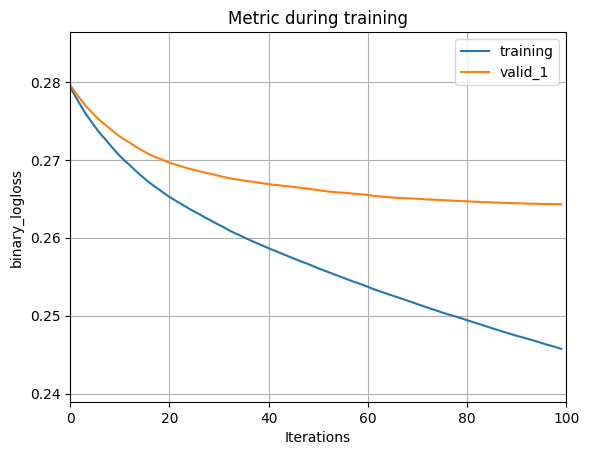

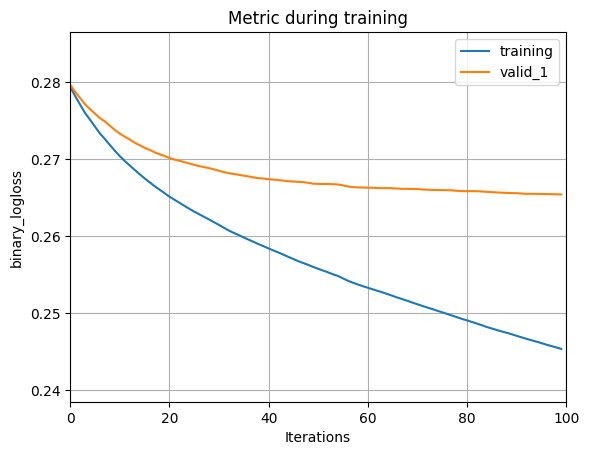

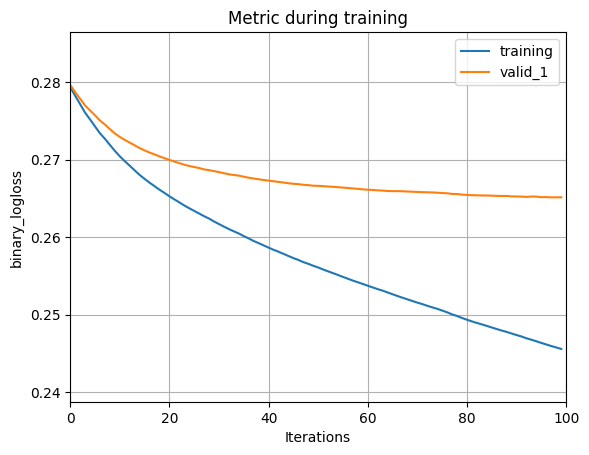

In [32]:
params = {
    "random_state": config["random_seed"],
    "nthread": config["num_threads"],
    }
evaluate_lgbm(data[predictors + ['TARGET']], params, hyperparams=hyperparams, config=config)

In [24]:
lgb_cross_evaluate(data[predictors + ['TARGET']], params=params)

[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Number of data points in the train set: 276756, number of used features: 19
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Warning] Unknown parameter: lamda_l1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Number of data points in the train set: 276756, number of used features: 1

{'valid binary_logloss-mean': [0.27943579835488225],
 'valid binary_logloss-stdv': [6.381802628889935e-05],
 'valid auc-mean': [0.632856452930912],
 'valid auc-stdv': [0.005957680466062493],
 'valid accuracy-mean': [0.9192701305767569],
 'valid accuracy-stdv': [1.5498886038743002e-05],
 'valid balanced accuracy-mean': [0.5],
 'valid balanced accuracy-stdv': [0.0],
 'valid recall-mean': [0.0],
 'valid recall-stdv': [0.0],
 'valid weighted_recall-mean': [0.9192701305767569],
 'valid weighted_recall-stdv': [1.5498886038743002e-05],
 'valid f1-mean': [0.0],
 'valid f1-stdv': [0.0],
 'valid precision-mean': [0.0],
 'valid precision-stdv': [0.0]}

# Essai sur des features sélectionnées

In [53]:
selected_features = joblib.load(os.path.join(MODEL_DIR, subdir, "selected_features_03.pkl"))
train = pd.read_csv(os.path.join(DATA_INTERIM, "train_simple_reduced_03.csv"), usecols=['SK_ID_CURR', 'TARGET'] + selected_features)
print("Forme de train :", train.shape)
train.head()

Forme de train : (191616, 19)


,SK_ID_CURR,TARGET,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN
0,100002,1.0,24700.5,-9461,-637.0,-2120,0.083037,0.262949,0.139376,0.121978,0.060749,1681.029,-103.0,780.0,-476.0,85.0,24.0,24.0,0.000000
1,100003,0.0,35698.5,-16765,-1188.0,-291,0.311267,0.622246,NaN,0.132217,0.027598,0.000,-606.0,1216.0,-775.0,-420.0,10.0,10.0,0.000000
2,100008,0.0,27517.5,-16941,-1588.0,-477,NaN,0.354225,0.621226,0.277955,0.056101,0.000,-78.0,471.0,-1097.0,-792.0,14.0,14.0,37.628571
3,100009,0.0,41301.0,-13778,-3130.0,-619,0.774761,0.724000,0.492060,0.241526,0.026463,0.000,-239.0,-209.0,-684.0,1044.0,8.0,8.0,0.137255
4,100011,0.0,33826.5,-20099,NaN,-3514,0.587334,0.205747,0.751724,0.300680,0.033176,5073.615,NaN,NaN,-1309.0,-860.0,14.0,14.0,7.946154


In [54]:
test = pd.read_csv(os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"), usecols=['SK_ID_CURR', 'TARGET'] + selected_features)
test = test[test['TARGET'].isnull()]
print("Forme de test :", test.shape)
test.head()

Forme de test : (48744, 19)


,SK_ID_CURR,TARGET,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN
307507,100001,NaN,20560.5,-19241,-2329.0,-812,0.752614,0.789654,0.159520,0.152300,0.036147,NaN,-49.0,411.0,-857.0,-179.0,8.000000,8.000000,1.571429
307508,100005,NaN,17370.0,-18064,-4469.0,-1623,0.564990,0.291656,0.432962,0.175455,0.077973,0.0,-62.0,122.0,-373.0,-128.0,12.000000,12.000000,0.111111
307509,100013,NaN,69777.0,-20038,-4458.0,-3503,NaN,0.699787,0.610991,0.344578,0.105202,19305.0,NaN,NaN,-1210.0,-567.0,17.333333,17.333333,0.541935
307510,100028,NaN,49018.5,-13976,-1866.0,-4208,0.525734,0.509677,0.612704,0.155614,0.031123,0.0,-269.0,-1105.0,-992.0,-452.0,11.333333,11.333333,0.265487
307511,100038,NaN,32067.0,-13040,-2191.0,-4262,0.202145,0.425687,NaN,0.178150,0.051266,NaN,NaN,NaN,NaN,NaN,24.000000,12.000000,0.000000


In [15]:
# Essai sur un échantillon d'abord
n_rows = 30_000
X_train = train.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)
y_train = train["TARGET"]
if n_rows:
    X_train = X_train.sample(n_rows, random_state=42)
    y_train = y_train.sample(n_rows, random_state=42)

In [16]:
predictors = list(X_train.columns)
predictors

['AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN']

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 176776 to 159030
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AMT_ANNUITY                       29998 non-null  float64
 1   DAYS_BIRTH                        30000 non-null  int64  
 2   DAYS_EMPLOYED                     27634 non-null  float64
 3   DAYS_ID_PUBLISH                   30000 non-null  int64  
 4   EXT_SOURCE_1                      21057 non-null  float64
 5   EXT_SOURCE_2                      29959 non-null  float64
 6   EXT_SOURCE_3                      25501 non-null  float64
 7   ANNUITY_INCOME_PERC               29998 non-null  float64
 8   PAYMENT_RATE                      29998 non-null  float64
 9   BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  20999 non-null  float64
 10  ACTIVE_DAYS_CREDIT_MAX            23650 non-null  float64
 11  ACTIVE_DAYS_CREDIT_ENDDATE_MIN    22907 non-null  float64
 12  CLO

In [18]:
X_test = test.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)

# Modèle

Partage du Train en train et validation, séparation de la target (PAS de validation croisée)

In [55]:
train, val = train_test_split(train, test_size=0.25, stratify=train['TARGET'], shuffle=True, random_state=42)

y_train = train['TARGET']
y_val = val['TARGET']
X_train = train.drop('TARGET', axis=1).set_index('SK_ID_CURR')
X_val = val.drop('TARGET', axis=1).set_index('SK_ID_CURR')

# Imputation avec la médiane
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train)
X_train_imputed = median_imputer.transform(X_train)
X_val_imputed = median_imputer.transform(X_val)

X_val.to_csv(os.path.join(DATA_INTERIM, "X_val.csv"))
print("Forme du jeu de validation :", X_val.shape)
y_val.to_csv(os.path.join(DATA_INTERIM, "y_val.csv"))
print("Forme de Target de validation :", y_val.shape)

X_train.to_csv(os.path.join(DATA_INTERIM, "X_train.csv"))
print("\nForme du jeu d'entraînement' :", X_train.shape)
y_train.to_csv(os.path.join(DATA_INTERIM, "y_train.csv"))
print("Forme de Target d'entraînement' :", y_train.shape)

Forme du jeu de validation : (47904, 17)
Forme de Target de validation : (47904,)

Forme du jeu d'entraînement' : (143712, 17)
Forme de Target d'entraînement' : (143712,)


# Imputation

In [19]:
"""median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train)
X_train_imputed = median_imputer.transform(X_train)
X_test_imputed = median_imputer.transform(X_test)"""

# Fonctions d'apprentissage et metrique  MLFlow

fonction d'apprentissage MLFlow

In [56]:
def train_mlflow(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    
    print(f"Train Accuracy:{train_acc:.3%}")

Métrique MLFlow

In [ ]:
# [TODO]
# Définir ici une métrique spéciale qui pénalise le recall des defaut ?
# Pour l'instant on met l'accuracy, MLFlow devrait tracer ça pour chaque run

# Fonction d'évaluation MLFlow

In [72]:
def plot_roc_curve(sk_model, X_test, y_test):
    preds = sk_model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label='ROC Curve (sklearn)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    #plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    

In [91]:
def plot_confusion_matrix(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0f",
        vmin=0,
        linewidths=0.5,
        cmap="Blues",
        # cbar_kws={"format": self.format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig

In [117]:
def format_percent(x, _):
        return f"{x * 100:.0f}%"

def plot_precision(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred, normalize="pred")
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0%",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cmap="Blues",
        cbar_kws={"format": format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion en % par colonne (Précision)")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig


def plot_recall(y_true, y_pred, figsize=(5, 4)):
    conf_mat = confusion_matrix(y_true, y_pred, normalize="true")
    conf_mat_df = pd.DataFrame(
        conf_mat,
        index=["Ok", "Défaut"],
        columns=["Ok", "Défaut"],
        )
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat_df,
        annot=True,
        fmt=".0%",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cmap="Blues",
        cbar_kws={"format": format_percent},
        ax=ax,
    )
    fig.suptitle("Matrice de confusion en % par ligne (Recall)")
    plt.yticks(rotation=0)
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Vraie catégorie")
    return fig

In [77]:
def custom_f1(tn, fp, fn, tp, weight_fn=0.9):
    # f1 standard = 2 * tp / (2 * tp + fp + fn)
    weighted_f1 = 2 * tp / (2 * tp + weight_fn * fn  + (1 - weight_fn) * fp)
    return weighted_f1

In [25]:
#from sklearn.metrics import classification_report

In [118]:
def evaluate_mlflow(sk_model, X_val, y_val):
    eval_acc = sk_model.score(X_val, y_val)
    
    preds = sk_model.predict(X_val)
    auc_score = roc_auc_score(y_val, preds)
    
    # On extrait les valeurs de la matrice de confusion
    conf_matrix = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    weighted_f1 = custom_f1(tn, fp, fn, tp)
    
    dic_metrics = {"eval_acc": eval_acc, "roc_auc_score": auc_score, "weighted_f1": weighted_f1}
    
        
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    print(f"Weighted f1: {weighted_f1:.3%}")
    # Plot de la courbe ROC
    plot_roc_curve(
        sk_model,
        X_val,
        y_val,
        #name = 'ROC Curve (sklearn)',
        )
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    
    
    # Plot Matrice de confusion
    plot_confusion_matrix(y_val, preds)
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    
    # Plot Matrice de confusion normalisée True
    plot_recall(y_val, preds)
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_recall.png"))
    
    # Plot Matrice de confusion normalisée Pred
    plot_precision(y_val, preds)
    
    report = classification_report(y_val, preds)
    print(report)
    
    # Traçage mlflow
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_recall.png"))
    return dic_metrics

# Premier modèle pour tester ML FLOW

In [79]:
sk_model = LogisticRegression(
    max_iter=400,
    solver='newton-cg',
    random_state=42,
)

In [80]:
sk_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Première expérience mlflow

In [ ]:
"""
Démarrer un serveur mlflow local en ligne de commande :
mlflow server --host 127.0.0.1 --port 8080
"""

In [115]:
# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri(LOCAL_URI)

2024/05/03 11:17:00 INFO mlflow.tracking.fluent: Experiment with name 'Régression Logistique' does not exist. Creating a new experiment.
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Train Accuracy:87.094%
Auc Score: 51.379%
Eval Accuracy: 87.141%
Weighted f1: 6.641%


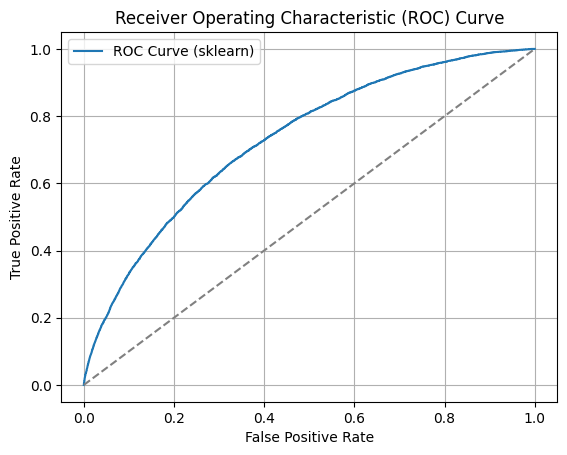

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     41698
         1.0       0.57      0.03      0.06      6206

    accuracy                           0.87     47904
   macro avg       0.72      0.51      0.49     47904
weighted avg       0.83      0.87      0.82     47904

Model run: e77706ea94f840598148031f18b64222
run.info : <RunInfo: artifact_uri='mlflow-artifacts:/127285067532811628/e77706ea94f840598148031f18b64222/artifacts', end_time=None, experiment_id='127285067532811628', lifecycle_stage='active', run_id='e77706ea94f840598148031f18b64222', run_name='Premier run expérimental', run_uuid='e77706ea94f840598148031f18b64222', start_time=1714727820859, status='RUNNING', user_id='Ariane'>


e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


<Figure size 640x480 with 0 Axes>

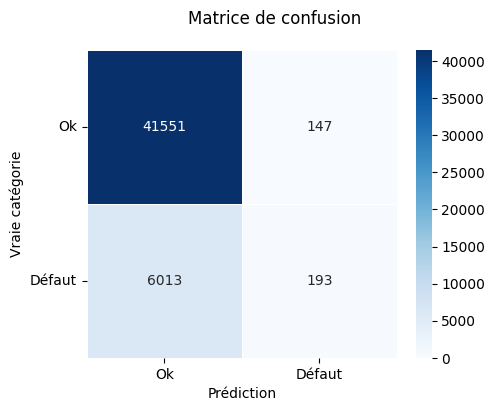

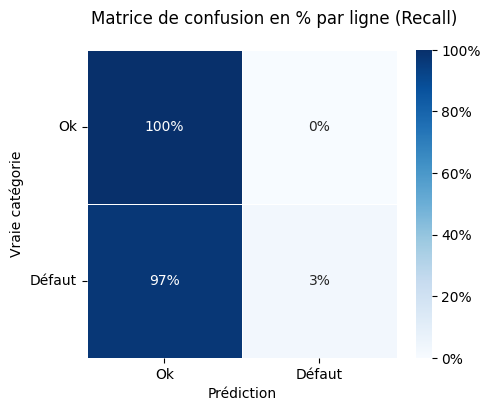

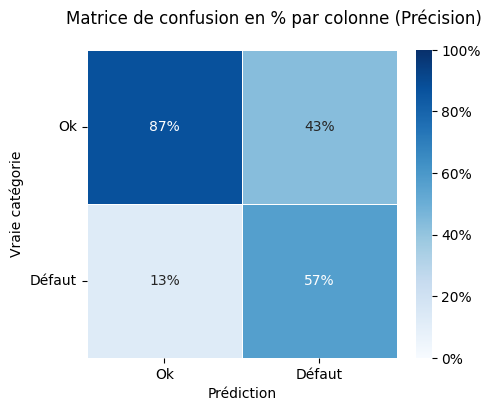

In [119]:
# Traçage de l'expérience
mlflow.set_experiment("Régression Logistique")
with mlflow.start_run(run_name="Premier run expérimental") as run:
    # Entraînement
    train_mlflow(sk_model, X_train_imputed, y_train)
    # Validation
    dic_metrics = evaluate_mlflow(sk_model, X_val_imputed, y_val)
    
    # Log  metrics that were calculated during validation
    mlflow.log_metrics(dic_metrics)
    # Log the parameters used for the model fit
    mlflow.log_params(sk_model.get_params())
    # Log an instance of the trained model for later use
    #mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)
    mlflow.sklearn.log_model(sk_model, "Test 0 de mlflow sur une reg log")
    print("Model run:", mlflow.active_run().info.run_uuid)
    print("run.info :", run.info)
# Force mlflow à terminer le run même s'il y a une erreur dedans
mlflow.end_run()



Voir le résultat dans un navigateur
Dans firefox, http://127.0.0.1:8080

# Sauvegarde du modèle

In [42]:
joblib.dump(sk_model, os.path.join(MODEL_DIR, "clf_reglog_test0.pkl"))

['models/clf_reglog_test0.pkl']

# Recherche d'un Run

In [ ]:
# Le client c'est pour interroger mlflow
# For example, the following code snippet search for runs that has the best validation loss among all runs in the experiment.
client = mlflow.tracking.MlflowClient()
experiment_id = "0"
best_run = client.search_runs(
    experiment_id, order_by=["metrics.val_loss ASC"], max_results=1
)[0]
print(best_run.info)
# {'run_id': '...', 'metrics': {'val_loss': 0.123}, ...}


# Test du modèle

Charger un modèle loggé

In [53]:
loaded_model = mlflow.sklearn.load_model(
    #"runs://a1c3ff54285f47fa88f5d823d08dc943/'Test 0 de mlflow sur une reg log'"
    #"mlruns/935863330358510444/a1c3ff54285f47fa88f5d823d08dc943/artifacts"
    "runs://a1c3ff54285f47fa88f5d823d08dc943/artifacts"
)

MlflowException: Not a proper runs:/ URI: runs://a1c3ff54285f47fa88f5d823d08dc943/. Runs URIs must be of the form 'runs:/<run_id>/run-relative/path/to/artifact'

Tester le modèle

In [ ]:
loaded_model.score(X_test, y_test)

# MLFlow

Démarrer le serveur mlflow

In [ ]:
"""
Démarrer un serveur mlflow en local :
mlflow server --host 127.0.0.1 --port 8080
"""

'\nDémarrer un serveur mlflow en local :\nmlflow server --host 127.0.0.1 --port 8080\n'

Initialiser un client mlflow

In [ ]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

client = MlflowClient(tracking_uri=URI_LOCAL)

Création d'une nouvelle expérience mlflow

In [ ]:
"""experiment_description = (
    "OC P7 Implémentez un modèle de Scoring"
    "Modèle LightGBM - Mode Debug"
)

experiment_tags = {
    "project_name": "p7",
    "store_dept": "produce",
    "team": "oc",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

lightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)"""

'experiment_description = (\n    "OC P7 Implémentez un modèle de Scoring"\n    "Modèle LightGBM - Mode Debug"\n)\n\nexperiment_tags = {\n    "project_name": "p7",\n    "store_dept": "produce",\n    "team": "oc",\n    "project_quarter": "Q1-2024",\n    "mlflow.note.content": experiment_description,\n}\n\nlightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)'

Rechercher l'expérience avec le nom du projet

In [ ]:
# Use search_experiments() to search on the project_name tag key

lightgbm_debug_experiment = client.search_experiments(
    filter_string="tags.'project_name' = 'p7'"
)

pprint(lightgbm_debug_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/768052023167465751', creation_time=1713797424132, experiment_id='768052023167465751', last_update_time=1713797424132, lifecycle_stage='active', name='lightgbm_debug', tags={'mlflow.note.content': 'OC P7 Implémentez un modèle de ScoringModèle LightGBM '
                        '- Mode Debug',
 'project_name': 'p7',
 'project_quarter': 'Q1-2024',
 'store_dept': 'produce',
 'team': 'oc'}>


In [ ]:
# Access individual tag data

print(lightgbm_debug_experiment[0].tags["team"])

oc


## Démarrer un run mlflow

In [ ]:
import mlflow

# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri(URI_LOCAL)

# Sets the current active experiment to the "Apple_Models" experiment and returns the Experiment metadata
lightgbm_debug_experiment = mlflow.set_experiment("lightgbm_debug")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "lightgbm_debug_test"

# Define an artifact path that the model will be saved to.
artifact_path = "lightgbm_debug"

In [14]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

"""params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}"""

LIGHTGBM_PARAMS = {
    "boosting_type": "goss",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(LIGHTGBM_PARAMS)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)

2024/04/20 10:03:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\mlflow\types\utils.py:394: UserWarning:

#### Success!

You've just logged your first MLflow model! 

Navigate to the MLflow UI to see the run that was just created (named "apples_rf_test", logged to the Experiment "Apple_Models"). 